Alex Albaugh.  Wayne State.  CHE 5995/7507.  Lecture 23.  Winter 2026.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sklearn
import pandas as pd
import random

In [2]:
#order for CHE 7507 presentations
names = ['Adnan','Ali','Evan','Tareq']
random.shuffle(names)
for i,n in enumerate(names):
  print('Spot '+str(i+1)+': '+n)

Spot 1: Evan
Spot 2: Adnan
Spot 3: Tareq
Spot 4: Ali


# **Classification Trees**

We can use decision trees to solve classification problems.  As an example, we'll look at the phase diagram of a $\mathrm{C_{16} E_{8}}$ surfactant with water.  This surfactant has a 16 carbon hydrophobic tail and a hydrophilic head of 8 elythene oxide units.  We'll examine the phase a function of temperature in Celcius and weight fraction of surfactant.  The possible phases are:
- $\mathrm{L_{1}}$: spherical micelles in water
- $\mathrm{L_{2}}$: reverse micelles, water droplets in surfactant
- $\mathrm{L_{\alpha}}$: lamellar phase, alternating layers of surfactant and water
- $\mathrm{V_{1}}$: vesicle phase, closed double bilayers
- $\mathrm{S}$: solid phase
- $\mathrm{H_{1}}$: hexagonal phase, hexagonally packed surfactant cylinders
- $\mathrm{I_{1}}$: cubic phase, cubically arranged micelles
- $\mathrm{Water + L}$: distinct liquid surfactant and water phases

This data set is adapted from <url>https://pubs.acs.org/doi/full/10.1021/acs.jpcb.2c08232</url>.


In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/albaugh/CHE7507/refs/heads/main/Lecture23/C16E8_data.csv')
df.head()

,surfactant,temperature_(degC),composition_(wt%),observed_phase
0,C16E8,20,0.20,L1
1,C16E8,20,0.70,S
2,C16E8,40,0.25,L1
3,C16E8,75,0.45,L1
4,C16E8,55,0.95,L2


Our labels will be the <code>observed\_phase</code> column, the abbreviation for the phase.  Our features will be the temperature in Celcius and the weight percent of surfactant.

In [4]:
#labels are surfactant-water phases
y_train = df['observed_phase']

#features are temperature and composition
features = ['composition_(wt%)','temperature_(degC)']
feature_names = [ 'composition (mass frac.)', 'temperture (C)']
X_train = df[features].values

Let's first take a look at our phase diagram, where each (temperature, concentration) point from an experiment is colored according to the observed phase.

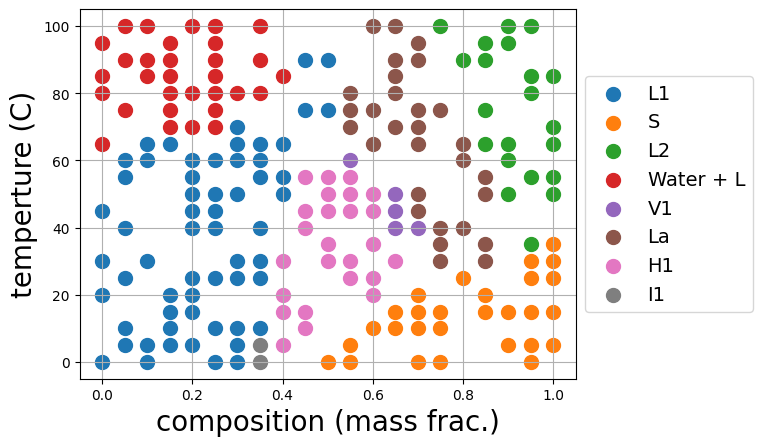

In [5]:
#get the unique phases for this surfactant system
categories = df['observed_phase'].unique()

#set up a unique color for each phase
colors = plt.cm.tab10.colors[:len(categories)]

#plot scatter points in each phase individually
fig,ax = plt.subplots()
for cat, col in zip(categories, colors):
  indices = (y_train == cat).values #get all of the data points with this label
  ax.scatter(X_train[indices, 0], X_train[indices, 1], s=100, label=cat, color=col) #plot all of the data points with this label

ax.set_xlabel(feature_names[0],fontsize=20)
ax.set_ylabel(feature_names[1],fontsize=20)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),fontsize=14)
ax.grid()
plt.show()

We'll now see how to train a decision tree classifier.  It lives in <code>sklearn</code>'s <code>tree</code> library.  It is called <code>DecisionTreeClassifier</code>.  Important features to specify are the decision criterion, <code>criterion</code> and <code>max\_depth</code>.  The decision criterion is usually <code>'gini'</code> or <code>'entropy'</code>.  The maximum depth of the tree is the maximum number of nodes between the first node and the leaves.  
We'll first train a decision tree with no maximum depth.  This tree will keep splitting until every leaf is pure, even if this means the leaf has a single data point.  Such a tree is at risk for overfitting and will likely be overcomplex and no generalize well.

In [6]:
#initialize and train a decision tree for classification
dtc = sklearn.tree.DecisionTreeClassifier(criterion='gini', max_depth=None)
dtc.fit(X_train, y_train)

#make predictions on the training data
y_pred = dtc.predict(X_train)

#calculate the training accuracy
print('Accuracy:', np.round(100.0*sklearn.metrics.accuracy_score(y_train, y_pred),decimals=2),'%')

Accuracy: 100.0 %


As we might expect, because this tree splits until every node is pure, the training accuracy will be 100%.  Let's look at the tree structure.  We can get the maximum depth from the trained object with <code>.get\_depth</code> and we can get the number of leaves with <code>.get\_n\_leaves</code>.  We can also visualize the tree with <code>plot\_tree</code>.

In [7]:
print('Tree depth:', dtc.get_depth())
print('Leaves:',dtc.get_n_leaves())

Tree depth: 8
Leaves: 32


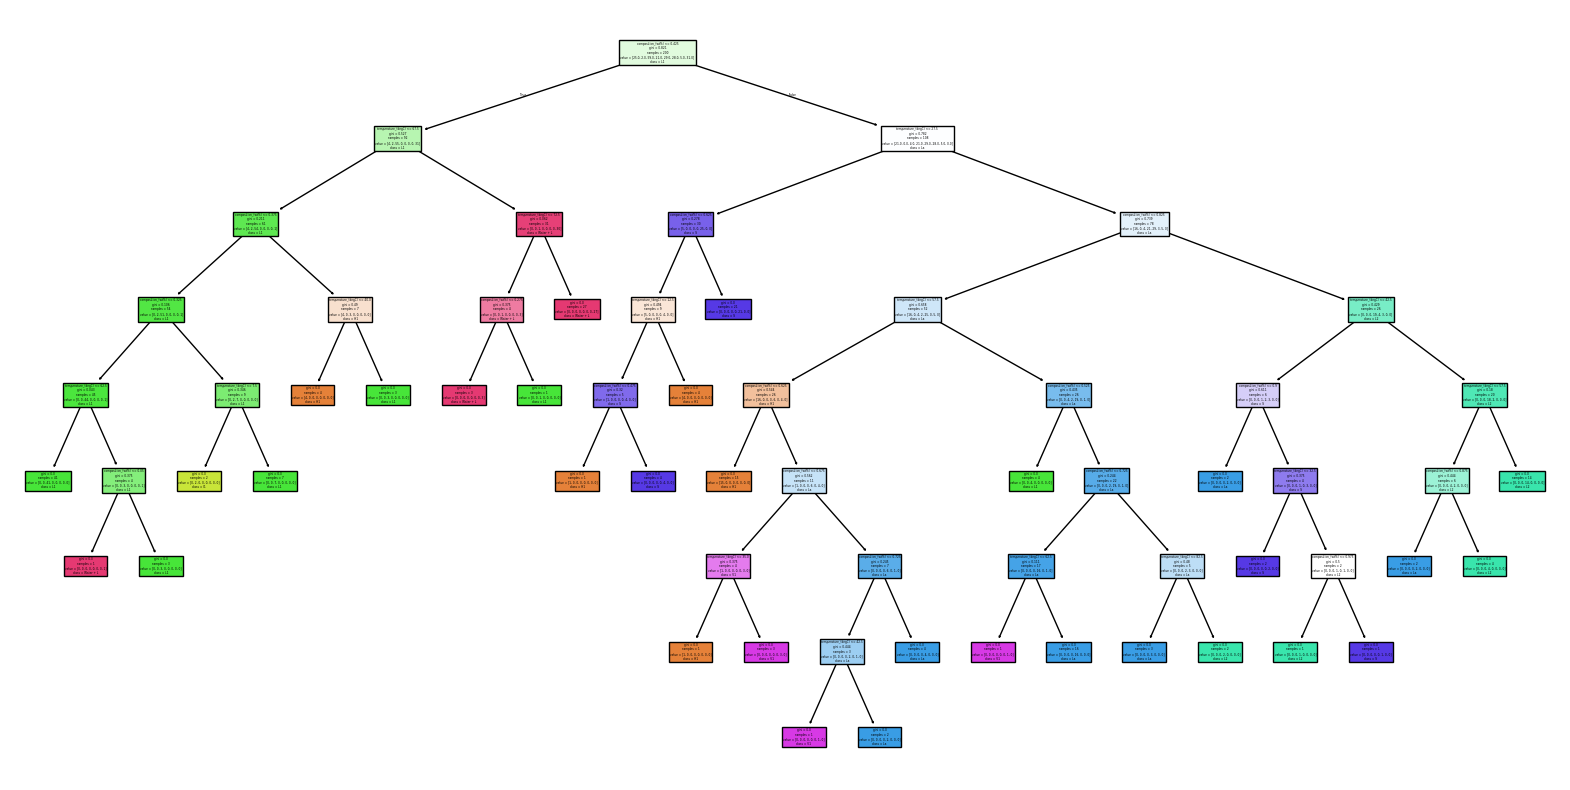

In [8]:
plt.figure(figsize=(20,10))
sklearn.tree.plot_tree(dtc, filled=True, feature_names=features, class_names=dtc.classes_)
plt.show()

The nodes and leaves are colored by purity.  Darker colors are purer nodes (they have a higher concentration of a single class).  The figure also shows the decision criterion at each node and the number of each class at each node.  This demonstrates that decision trees can be highly interpretable.  You can simply follow the tree yourself to make a prediction.

With the function below we can plot the full decision boundaries from our model.  Let's see what these look like for our tree.

In [9]:
#here's a function for plotting decision boundaries.

def plot_decision_boundaries(X, y, model):
  #grid of test points
  x_min = np.min(X[:,0])
  x_max = np.max(X[:,0])
  y_min = np.min(X[:,1])
  y_max = np.max(X[:,1])
  XX, YY = np.meshgrid(np.linspace(x_min, x_max, 1000), np.linspace(y_min, y_max, 1000))
  grid_points = np.c_[XX.ravel(), YY.ravel()]

  #map labels to integers
  classes = list(model.classes_)
  label_to_int = {label: i for i, label in enumerate(classes)}

  #map labels to colors
  colors = plt.cm.tab10.colors[:len(classes)]
  label_to_color = {label: color for label, color in zip(classes, colors)}
  colormap = matplotlib.colors.ListedColormap([label_to_color[cls] for cls in classes])

  #predict at each test point
  ZZ = model.predict(grid_points)

  #convert label predictions (ZZ) into integers (ZZ_int) for plotting purposes
  ZZ_int = np.vectorize(label_to_int.get)(ZZ).reshape(XX.shape)

  #plot the decision boundaries with a contour
  fig, ax = plt.subplots()
  ax.pcolormesh(XX, YY, ZZ_int, cmap=colormap, alpha=0.5)

  #plot the data points with consistent colors
  for cat in classes: #loop over all of the unique labels
      indices = (y == cat).values #get all of the data points with this label
      ax.scatter(X[indices, 0], X[indices, 1], s=100, label=cat, color=label_to_color[cat]) #plot all of the data points with this label

  ax.set_xlabel(feature_names[0],fontsize=20)
  ax.set_ylabel(feature_names[1],fontsize=20)
  ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),fontsize=14)

  ax.grid()
  plt.show()

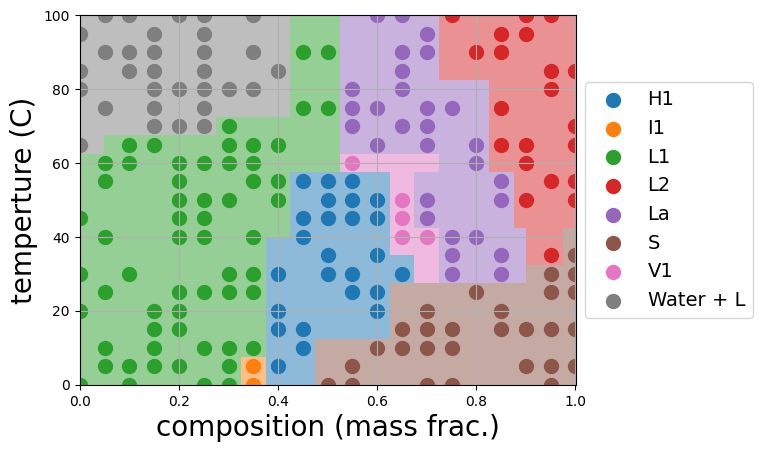

In [10]:
plot_decision_boundaries(X_train, y_train, dtc)

This looks pretty good, but remember that such a complex tree can be overfit.  Let's see how a simpler tree will do.  We can make a simpler tree by setting a maximum depth.

In [11]:
#initialize and train a decision tree for classification
dtc = sklearn.tree.DecisionTreeClassifier(criterion='gini', max_depth=3)
dtc.fit(X_train, y_train)

#make predictions on the training data
y_pred = dtc.predict(X_train)

#calculate the training accuracy
print('Accuracy:', np.round(100.0*sklearn.metrics.accuracy_score(y_train, y_pred),decimals=2),'%')

Accuracy: 77.5 %


In [12]:
print('Tree depth:', dtc.get_depth())
print('Leaves:',dtc.get_n_leaves())

Tree depth: 3
Leaves: 8


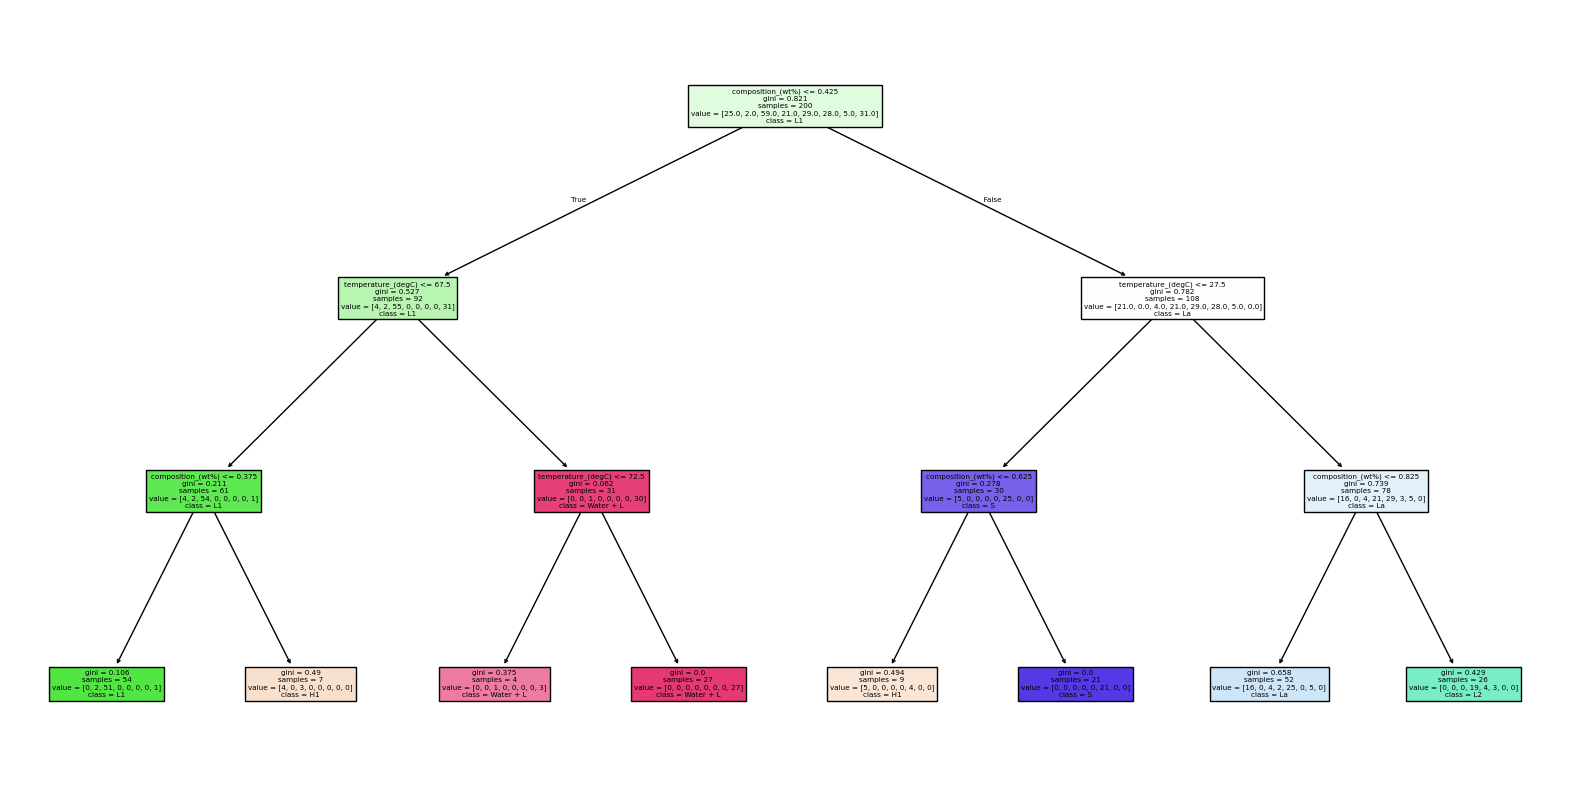

In [13]:
plt.figure(figsize=(20,10))
sklearn.tree.plot_tree(dtc, filled=True, feature_names=features, class_names=dtc.classes_)
plt.show()

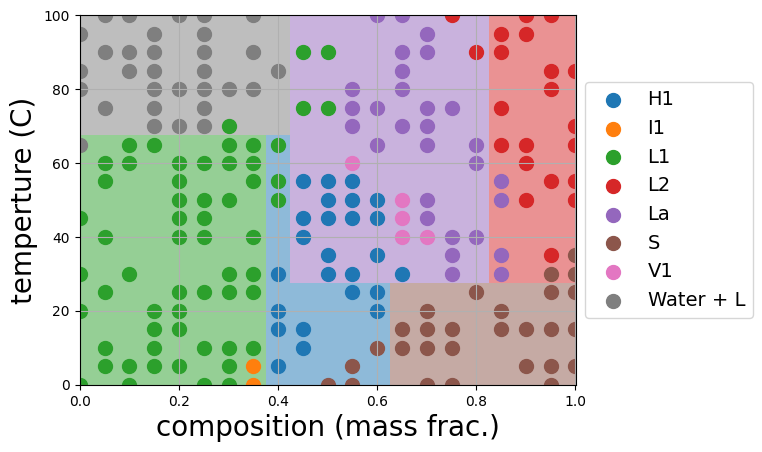

In [14]:
plot_decision_boundaries(X_train, y_train, dtc)

We can test a range of maxmim depths to see how tree complexity affects training accuracy.

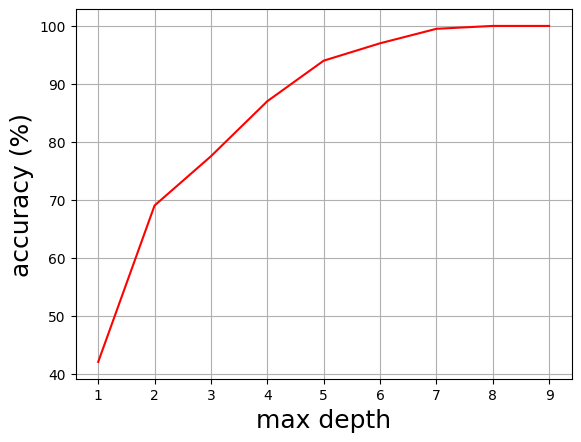

In [15]:
#test a range of maximum depths
max_depths = np.arange(1,10)

#container for storing accuracy with each maximum depth
accuracies = []

#loop over the maximum depths and fit a new tree for each
for md in max_depths:
  #set up and train a tree with this maximum depth
  dtc = sklearn.tree.DecisionTreeClassifier(criterion='gini', max_depth=md)
  dtc.fit(X_train, y_train)

  #make predictions on the training data
  y_pred = dtc.predict(X_train)

  #calculate and store training accuracy
  acc = sklearn.metrics.accuracy_score(y_train, y_pred)
  accuracies.append(acc)

#plot accuracy vs. maximum depth
fig,ax = plt.subplots()
ax.plot(max_depths, 100.0*np.array(accuracies), color='r')
ax.set_xlabel('max depth',fontsize=18)
ax.set_ylabel('accuracy (%)',fontsize=18)
ax.grid()
plt.show()


# **Pruning**

With tree pruning, we systematically collapse subtrees into leaves.  This reduces the number of leaves and depth.  This is a form of regularization, which means it will decrease our performance on training data, but increase performance on test data.  It is a way of preventing overfitting.  The degree of pruning is controlled by the $\alpha$ parameter (<code>ccp\_alpha</code> in the <code>DecisionTreeClassificer</code> function).  The method is called cost-complexity pruning.

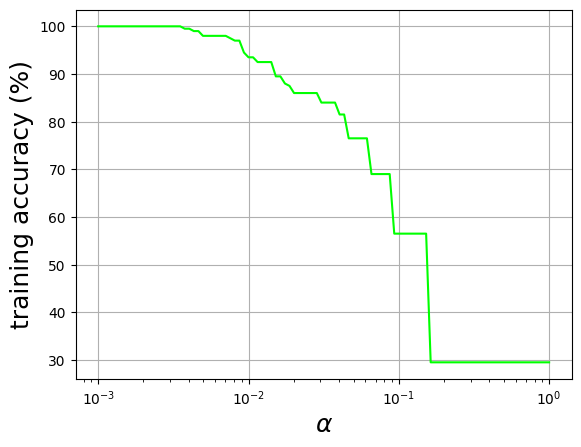

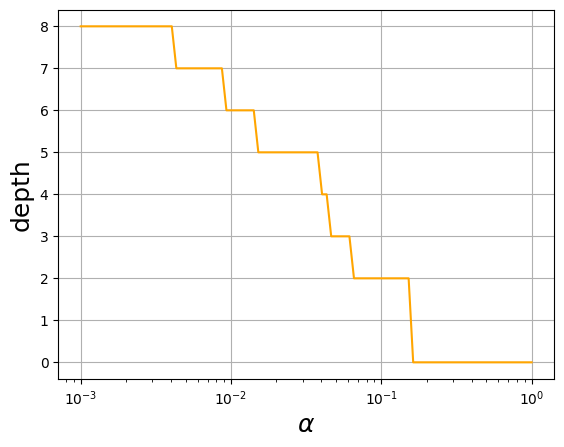

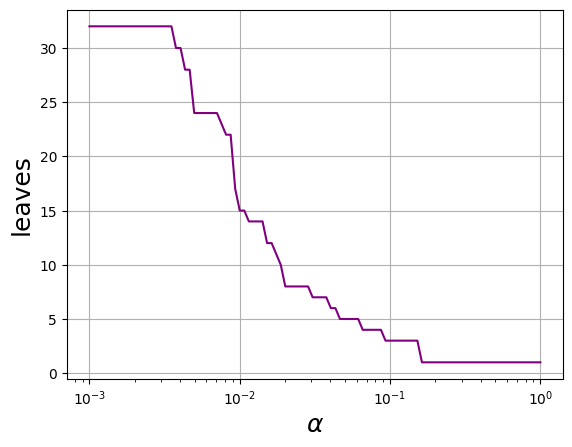

In [16]:
#set up a range of alpha values to test
ccp_alphas = np.logspace(-3, 0, 100)

#track the accuracy, depth, and number of leaves
accuracies = []
depths = []
leaves = []

#fit a tree for each alpha value
for cpa in ccp_alphas:
  #initialize and fit a decision tree with this alpha value
  dtc = sklearn.tree.DecisionTreeClassifier(criterion='gini', ccp_alpha=cpa)
  dtc.fit(X_train, y_train)

  #predict on the training data
  y_pred = dtc.predict(X_train)

  #record the accuracy, tree depth, and number of leaves
  acc = sklearn.metrics.accuracy_score(y_train, y_pred)
  accuracies.append(acc)
  depths.append(dtc.get_depth())
  leaves.append(dtc.get_n_leaves())

#plot the accuracy vs. alpha
fig,ax = plt.subplots()
ax.plot(ccp_alphas, 100.0*np.array(accuracies), color='lime')
ax.set_ylabel('training accuracy (%)',fontsize=18)
ax.set_xlabel('$\\alpha$',fontsize=18)
ax.set_xscale('log')
ax.grid()

#plot the tree depth vs. alpha
fig2,ax2 = plt.subplots()
ax2.plot(ccp_alphas, depths, color='orange')
ax2.set_ylabel('depth',fontsize=18)
ax2.set_xlabel('$\\alpha$',fontsize=18)
ax2.set_xscale('log')
ax2.grid()

#plot the number of leaves vs. alpha
fig3,ax3 = plt.subplots()
ax3.plot(ccp_alphas, leaves, color='purple')
ax3.set_ylabel('leaves',fontsize=18)
ax3.set_xlabel('$\\alpha$',fontsize=18)
ax3.set_xscale('log')
ax3.grid()

plt.show()

The real benefit of pruning is to improve test accuracy.  Here we don't have a test data set, so we'll use K-fold cross-validation to estimate the test error.  We'll use $K=5$.

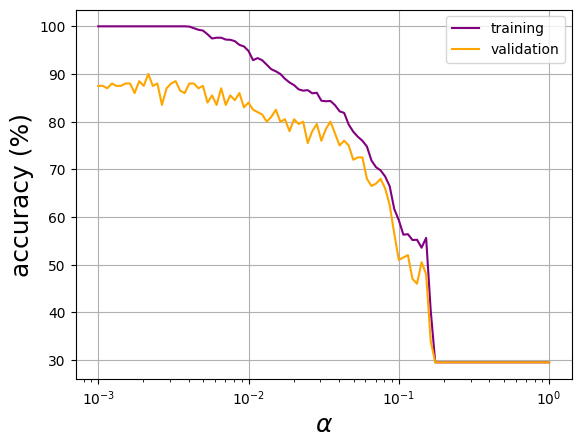

In [17]:
ccp_alphas = np.logspace(-3, 0, 100)

#containers for storing test and validation accuracy
training_accuracies = []
validation_accuracies = []

for cpa in ccp_alphas:
  #set up the tree and k-fold cross validation
  kf = sklearn.model_selection.KFold(n_splits=10, shuffle=True)
  dtc = sklearn.tree.DecisionTreeClassifier(criterion='gini', ccp_alpha=cpa)

  #this will apply the cross validation automatically and put the results in 'cv_results'
  #the scoring for a classifier is 'accuracy'
  cv_results = sklearn.model_selection.cross_validate(dtc, X_train, y_train, cv=kf, scoring='accuracy', return_train_score=True)

  #collect the errors from the validation
  training_acc = np.mean(cv_results['train_score'])
  validation_acc = np.mean(cv_results['test_score'])

  training_accuracies.append(training_acc)
  validation_accuracies.append(validation_acc)

#plot the training and validation accuracy vs. alpha
fig,ax = plt.subplots()
ax.plot(ccp_alphas, 100.0*np.array(training_accuracies), color='purple', label='training')
ax.plot(ccp_alphas, 100.0*np.array(validation_accuracies), color='orange', label='validation')
ax.legend()
ax.set_xlabel('$\\alpha$',fontsize=18)
ax.set_xscale('log')
ax.set_ylabel('accuracy (%)',fontsize=18)
ax.grid()
plt.show()

Based on the above analysis, we'll choose the $\alpha$ value with the highest validation accuracy.  We'll refit with this $\alpha$ and take a look at the resulting tree.

Optimal alpha: 0.0021544346900318843
Accuracy: 100.0 %
Tree depth: 8
Leaves: 32


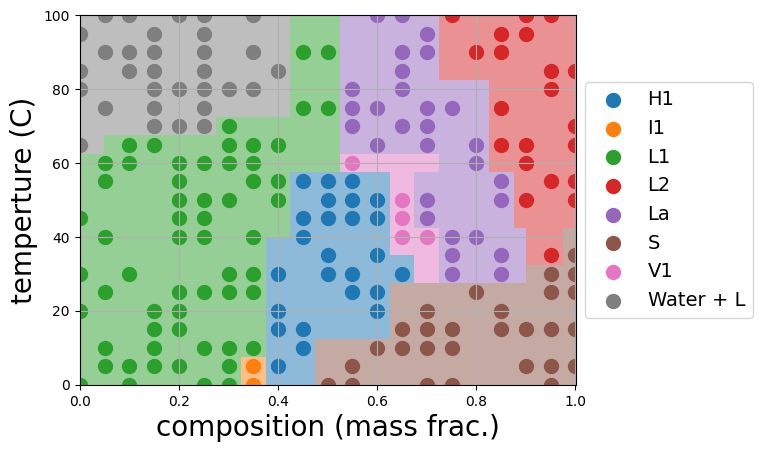

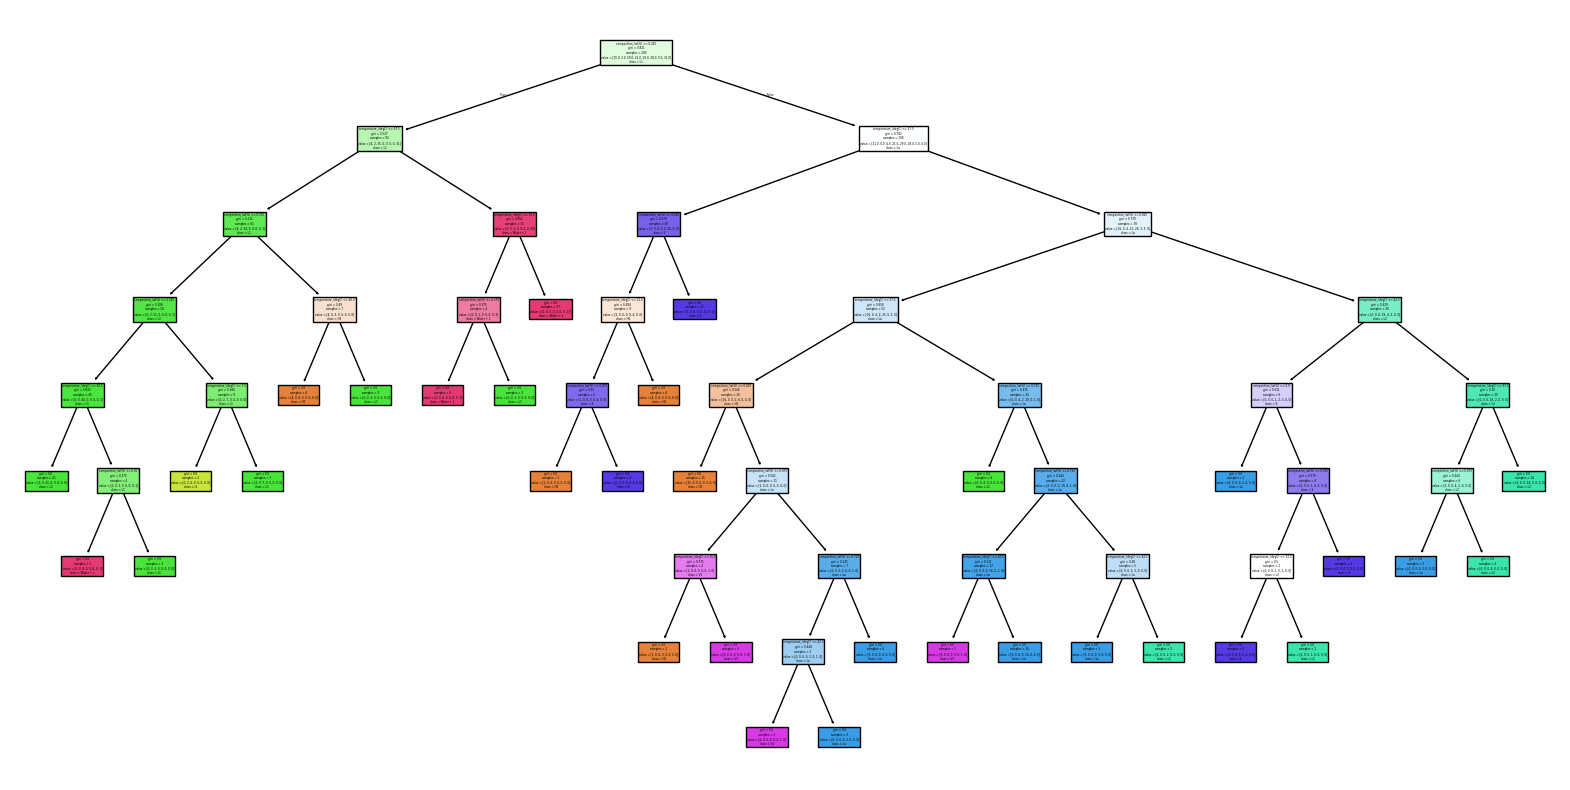

In [18]:
#get the optimal alpha
opt_alpha = ccp_alphas[np.argmax(validation_accuracies)]
print('Optimal alpha:', opt_alpha)

#fit with the optimal alpha
dtc = sklearn.tree.DecisionTreeClassifier(criterion='gini', ccp_alpha=opt_alpha)
dtc.fit(X_train, y_train)

#predict on training data
y_pred = dtc.predict(X_train)

#print the training accuracy, tree depth, and leaves
print('Accuracy:', np.round(100.0*sklearn.metrics.accuracy_score(y_train, y_pred),decimals=2),'%')
print('Tree depth:', dtc.get_depth())
print('Leaves:',dtc.get_n_leaves())

#plot decision boundaries
plot_decision_boundaries(X_train, y_train, dtc)

#visualize tree
plt.figure(figsize=(20,10))
sklearn.tree.plot_tree(dtc, filled=True, feature_names=features, class_names=dtc.classes_)
plt.show()

This isn't the best data set to demonstrate the power of pruning because the structure of the phases leads to very slean boundaries and an overfit tree actually performs well on test data.